# Emulating the LHC Output

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import cf_xarray

## Read inputs (parameter scaling factors)

In [3]:
x = xr.open_dataarray('./processed_data/lhc220926.nc')

In [4]:
x

<xarray.DataArray (param: 32, ens: 500)>
array([[0.778311, 0.319329, 0.876772, ..., 0.185969, 0.26213 , 0.422114],
       [0.358026, 0.548803, 0.210794, ..., 0.996422, 0.91228 , 0.839212],
       [0.255021, 0.630191, 0.662125, ..., 0.422209, 0.533934, 0.144342],
       ...,
       [0.393617, 0.041084, 0.819746, ..., 0.242643, 0.71595 , 0.21237 ],
       [0.078962, 0.275619, 0.840143, ..., 0.842275, 0.353015, 0.36344 ],
       [0.684588, 0.878455, 0.951915, ..., 0.731144, 0.358052, 0.15671 ]])
Coordinates:
  * param    (param) object 'FUN_fracfixers' 'KCN' ... 'tpuse_sf' 'wc2wjb0'
  * ens      (ens) object 'LHC0001' 'LHC0002' 'LHC0003' ... 'LHC0499' 'LHC0500'

In [5]:
x.shape

(32, 500)

In [6]:
xt = x.transpose()
xt.shape

(500, 32)

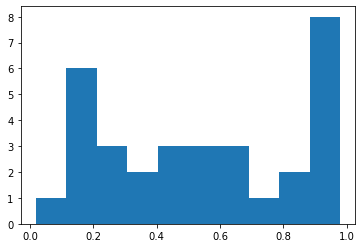

In [7]:
plt.hist(xt[100]);

In [10]:
y = xr.open_dataarray('./processed_data/fourvars_gmean_amean_2005-2014.nc')

In [11]:
y

<xarray.DataArray (var: 4, ens: 500)>
array([[2.488403e+00, 2.094031e+00, 3.763566e+00, ..., 1.735267e+00,
        1.792857e+00, 1.977623e+00],
       [3.832554e-05, 3.836190e-05, 4.283603e-05, ..., 2.776507e-05,
        2.816218e-05, 3.492068e-05],
       [3.061194e+01, 3.192346e+01, 2.667541e+01, ..., 2.939185e+01,
        3.349612e+01, 3.071059e+01],
       [4.678233e+01, 4.272905e+01, 4.868657e+01, ..., 3.957385e+01,
        3.842887e+01, 3.911139e+01]])
Coordinates:
  * var      (var) object 'TLAI' 'GPP' 'SOILWATER_10CM' 'EFLX_LH_TOT'
  * ens      (ens) object 'LHC0001' 'LHC0002' 'LHC0003' ... 'LHC0499' 'LHC0500'

In [12]:
y.shape

(4, 500)

In [ ]:
# left off adapting code here 10/12/22 - rescaling outputs is next

In [109]:
# Rescale the y values (x is already rescaled to [0,1])
#y_scale=y*86400 # convert GPP gC/m^2/s to gC/m^2/day (simple unit conversion does help somewhat)

# Standardize the y values: subtract the ensemble mean and divide by the ensemble standard deviation (see Baker et al. 2022)
y_scale = (y - y.mean())/y.std()

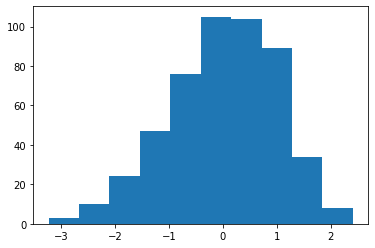

In [110]:
plt.hist(y_scale);

In [111]:
# Random seed for reproducibility
np.random.seed(9)

### Gaussian Process Regression
See: ``gp_regression.ipynb``

See: https://esem.readthedocs.io/en/latest/emulation.html#gaussian-processes-emulation

In [112]:
## gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Instantiate a Gaussian Process model
# key factors include setting up kernel, chosing alpha
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.1,normalize_y=True)

In [113]:
# Separate training/testing data: 80/20 split
# Randomly using sklearn
from sklearn.model_selection import train_test_split
x_train_GP,x_test_GP,y_train_GP,y_test_GP = train_test_split(xt,y_scale,test_size=0.2,train_size=0.8)

In [114]:
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x_train_GP, y_train_GP);

In [115]:
gp.kernel_

2.21**2 * RBF(length_scale=3.49)

In [116]:
# Testing data for prediction
y_pred, sigma = gp.predict(x_test_GP, return_std=True)

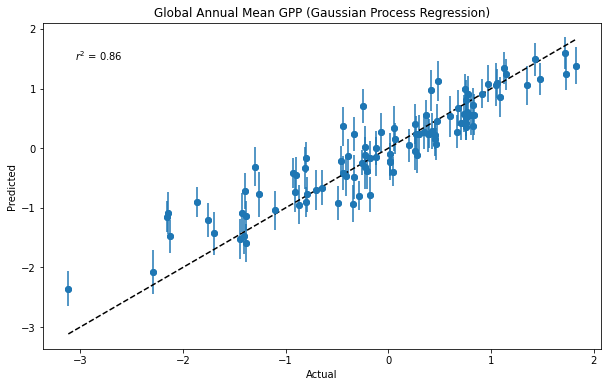

In [118]:
from scipy import stats

plt.figure(figsize=(10,6))
plt.scatter(y_test_GP,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

# standard deviation as error bars
plt.errorbar(y_test_GP,y_pred, yerr=sigma, fmt="o")

# bounds for one-to-one line
bounds = (np.amin([y_test_GP,y_pred]),np.amax([y_test_GP,y_pred]))

# one-to-one line
plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

# r^2 calculation and display
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_GP,y_pred)
pltstr = "$r^2$ = %.2g" % r_value**2
plt.text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', 
            transform=plt.gca().transAxes)

plt.title('Global Annual Mean GPP (Gaussian Process Regression)');
#plt.savefig('../figs/lhc/GPP_GM_AM_GPR_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

#### Emulate GPP vs. kmax with all other params set at 0.5
First using test data

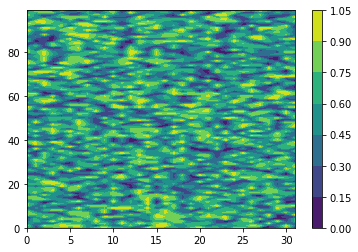

In [119]:
plt.contourf(x_test_GP)
plt.colorbar();

In [120]:
x_test_GP_kmax = x_test_GP.where(x_test_GP.param=='kmax', other=0.5)

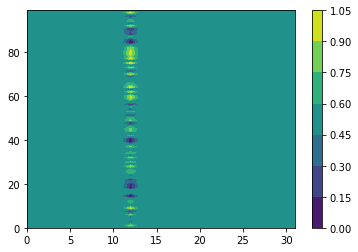

In [121]:
plt.contourf(x_test_GP_kmax)
plt.colorbar();

In [122]:
# Testing data for prediction
y_pred_kmax, sigma = gp.predict(x_test_GP_kmax, return_std=True)

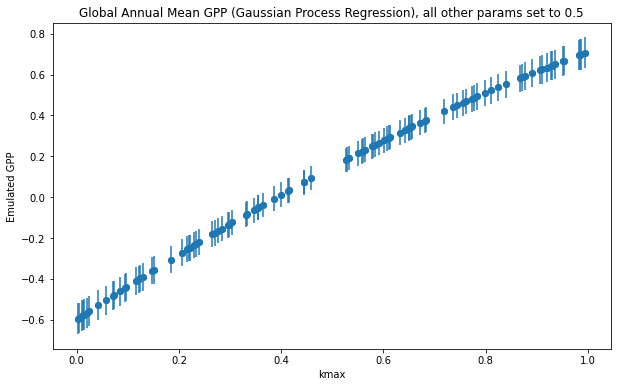

In [123]:
plt.figure(figsize=(10,6))
plt.scatter(x_test_GP.sel(param='kmax'), y_pred_kmax)
plt.xlabel('kmax')
plt.ylabel('Emulated GPP')

# standard deviation as error bars
plt.errorbar(x_test_GP.sel(param='kmax') ,y_pred_kmax, yerr=sigma, fmt="o")

plt.title('Global Annual Mean GPP (Gaussian Process Regression), all other params set to 0.5');
#plt.savefig('../figs/lhc/GPP_GM_AM_GPR_kmax_testdata.png', bbox_inches='tight')

Next using newly generated values (out of sample)

In [124]:
nsamp = 1000
x_oos = np.random.rand(nsamp,xt.shape[1])

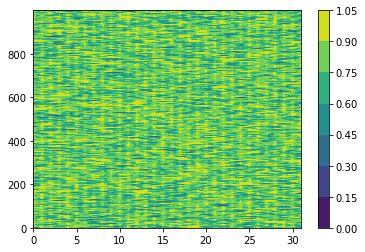

In [125]:
plt.contourf(x_oos)
plt.colorbar();

In [126]:
# label dimensions to enable parameter indexing
x_oos_da = xr.DataArray(x_oos,dims=('ens','param'),coords=dict(param=parameters))

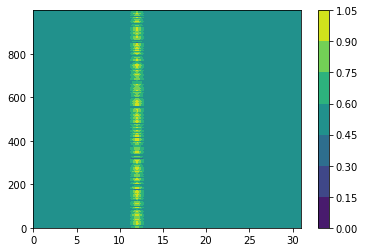

In [127]:
x_oos_kmax = x_oos_da.where(x_oos_da.param=='kmax', other=0.5)
plt.contourf(x_oos_kmax)
plt.colorbar();

In [128]:
y_pred_kmax_oos, sigma_oos = gp.predict(x_oos_kmax, return_std=True)

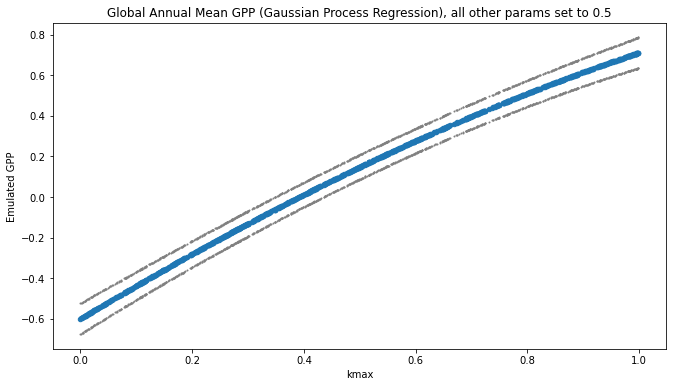

In [129]:
plt.figure(figsize=(11,6))
plt.scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos, label='GP Regression', s=20)
plt.xlabel('kmax')
plt.ylabel('Emulated GPP')

# standard deviation as error bars
#plt.errorbar(x_oos_da.sel(param='kmax') ,y_pred_kmax_oos, yerr=sigma_oos, fmt="o")
plt.scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos-sigma_oos, s=1, c='grey')
plt.scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos+sigma_oos, s=1, c='grey')

plt.title('Global Annual Mean GPP (Gaussian Process Regression), all other params set to 0.5');
#plt.savefig('../figs/lhc/GPP_GM_AM_GPR_kmax_oos.png', bbox_inches='tight')

### Neural Network

In [130]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import keras.backend as K

Using TensorFlow backend.
/glade/work/kdagon/miniconda/envs/ppe-py-ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glade/work/kdagon/miniconda/envs/ppe-py-ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glade/work/kdagon/miniconda/envs/ppe-py-ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [131]:
inputdata=xt
outputdata=y_scale

In [155]:
# Separate training/testing/validation data: 60/20/20 split
xi,x_test,yi,y_test = train_test_split(inputdata,outputdata,test_size=0.2,train_size=0.8)
x_train,x_val,y_train,y_val = train_test_split(xi,yi,test_size=0.25,train_size=0.75)

In [156]:
# Create 2-layer simple model
model = Sequential()

# specify input_dim as number of parameters, not number of simulations
# test 10 nodes in first hidden layer
# l2 norm regularizer
model.add(Dense(10, input_dim=inputdata.shape[1], activation='relu', kernel_regularizer=l2(.001)))

# second layer with hyperbolic tangent activation
# test 5 nodes in second hidden layer
model.add(Dense(5, activation='tanh', kernel_regularizer=l2(.001)))

# output layer with linear activation
model.add(Dense(1))
#model.add(Dense(nmodes)) # for multiple outputs (e.g., GPP and LHF)

In [157]:
# Define model metrics
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

In [158]:
# Compile model with RMSprop optimization

# define learning rate
lr = 0.005
#lr = 0.01

#opt_dense = RMSprop(lr=0.005, rho=0.9, epsilon=1e-07, decay=0.0)
opt_dense = RMSprop(lr=lr)
model.compile(opt_dense, "mse", metrics=[mean_sq_err])

In [159]:
# Fit the model w/ EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=1, patience=50, verbose=1, mode='min')
results = model.fit(x_train, y_train, epochs=500, batch_size=30, callbacks=[es], verbose=0, validation_data=(x_test,y_test))

# Fit the model w/o EarlyStopping
#results = model.fit(x_train, y_train, epochs=500, batch_size=30, verbose=0, validation_data=(x_test,y_test))

Epoch 00051: early stopping


In [160]:
print("Training Mean Error:", results.history['mean_sq_err'][-1])
print("Validation Mean Error:", results.history['val_mean_sq_err'][-1])

Training Mean Error: 0.18512662
Validation Mean Error: 0.33079636096954346


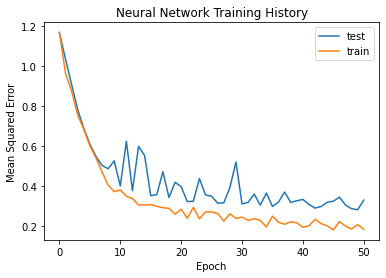

In [161]:
# Plot training history by epoch
plt.plot(results.epoch, results.history['val_mean_sq_err'], label='test')
plt.plot(results.epoch, results.history['mean_sq_err'], label='train')
#plt.xticks(results.epoch)
plt.legend()
#plt.hlines(y=0,xmin=0,xmax=15)
#plt.hlines(y=0,xmin=0,xmax=40)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.title('Neural Network Training History');

In [162]:
# Make predictions - using validation set
model_preds = model.predict(x_val)[:,0]

In [163]:
# model metric for predictions
def mse_preds(y_true,y_pred):
    return np.mean((y_true-y_pred)**2)

In [164]:
# calculate model mean error with predictions
model_me = mse_preds(y_val, model_preds)
print("Prediction Mean Error: ", model_me.values)

Prediction Mean Error:  0.1786855182090744


In [165]:
# linear regression of actual vs predicted
slope, intercept, r_value, p_value, std_err = stats.linregress(y_val, model_preds)

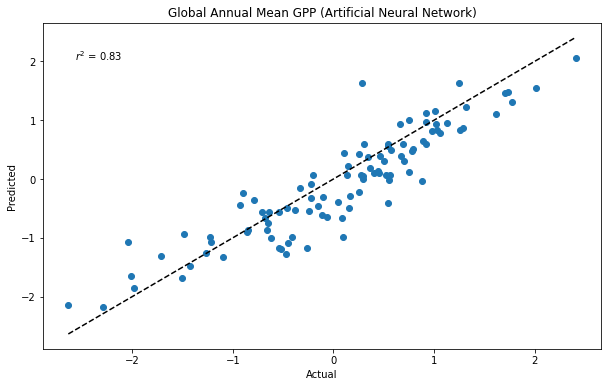

In [167]:
# plot actual vs. predicted
plt.figure(figsize=(10,6))
plt.scatter(y_val,model_preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')

# bounds for one-to-one line
bounds = (np.amin([y_val,model_preds]),np.amax([y_val,model_preds]))

# one-to-one line
plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--')

# r^2 value
pltstr = "$r^2$ = %.2g" % r_value**2
plt.text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', 
            transform=plt.gca().transAxes)

plt.title('Global Annual Mean GPP (Artificial Neural Network)');
#plt.savefig('../figs/lhc/GPP_GM_AM_NN_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

#### Emulate GPP vs. kmax with all other params set at 0.5
First using validation data

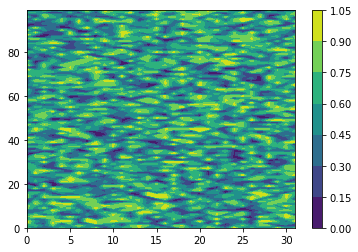

In [168]:
plt.contourf(x_val)
plt.colorbar();

In [169]:
x_val_kmax = x_val.where(x_val.param=='kmax', other=0.5)

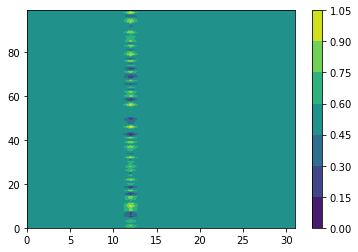

In [170]:
plt.contourf(x_val_kmax)
plt.colorbar();

In [171]:
# Validation data for prediction
model_preds_kmax = model.predict(x_val_kmax)[:,0]

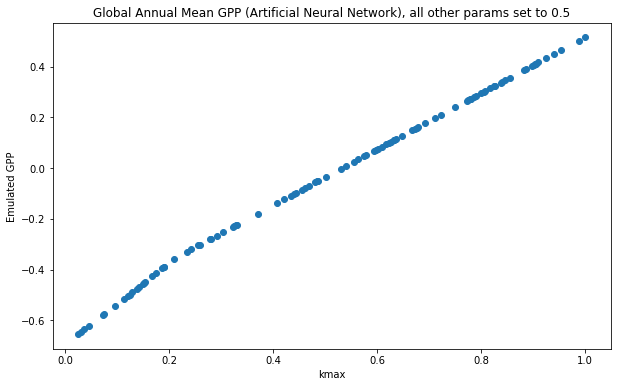

In [172]:
plt.figure(figsize=(10,6))
plt.scatter(x_val.sel(param='kmax'), model_preds_kmax)
plt.xlabel('kmax')
plt.ylabel('Emulated GPP')

plt.title('Global Annual Mean GPP (Artificial Neural Network), all other params set to 0.5');
#plt.savefig('../figs/lhc/GPP_GM_AM_NN_kmax_testdata.png', bbox_inches='tight')

Next using newly generated values (out of sample)

In [173]:
model_preds_kmax_oos = model.predict(x_oos_kmax)[:,0]

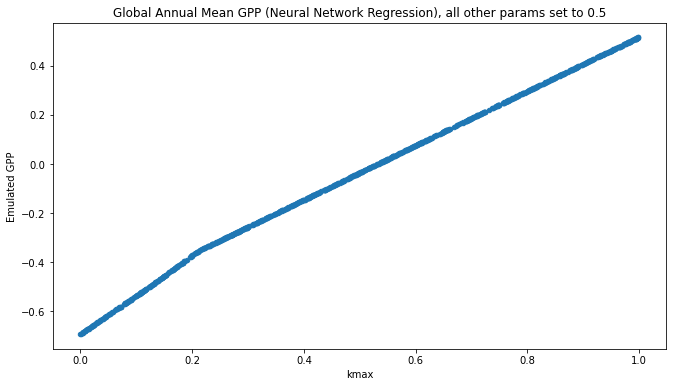

In [174]:
plt.figure(figsize=(11,6))
plt.scatter(x_oos_da.sel(param='kmax'), model_preds_kmax_oos, label='NN Regression', s=20)
plt.xlabel('kmax')
plt.ylabel('Emulated GPP')

plt.title('Global Annual Mean GPP (Neural Network Regression), all other params set to 0.5');
#plt.savefig('../figs/lhc/GPP_GM_AM_NN_kmax_oos.png', bbox_inches='tight')

### Compare response curves

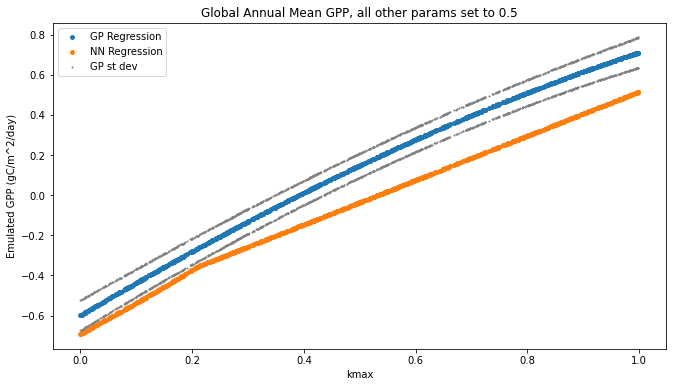

In [175]:
plt.figure(figsize=(11,6))
plt.scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos, label='GP Regression', s=15)
plt.scatter(x_oos_da.sel(param='kmax'), model_preds_kmax_oos, label='NN Regression', s=15)
plt.xlabel('kmax')
plt.ylabel('Emulated GPP (gC/m^2/day)')

# standard deviation as error bars
#plt.errorbar(x_oos_da.sel(param='kmax') ,y_pred_kmax_oos, yerr=sigma_oos, fmt="o")
plt.scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos-sigma_oos, s=1, c='grey', label='GP st dev')
plt.scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos+sigma_oos, s=1, c='grey')

plt.legend()

plt.title('Global Annual Mean GPP, all other params set to 0.5');
#plt.savefig('../figs/lhc/GPP_GM_AM_GPR_NN_kmax_oos.png', bbox_inches='tight')